In [47]:
using Plots
using LinearAlgebra
using Random

pyplot()
;

Define the logistic function and the gradients with respect to its parameters

In [32]:
f(x, β, β₀) = (1 + exp(-(x⋅β + β₀)))^-1
∂ᵦ₀f(x, β, β₀) = exp(-(x⋅β + β₀)) * f(x, β, β₀)^2
∇ᵦf(x, β, β₀) = x * ∂ᵦ₀f(x, β, β₀)
;

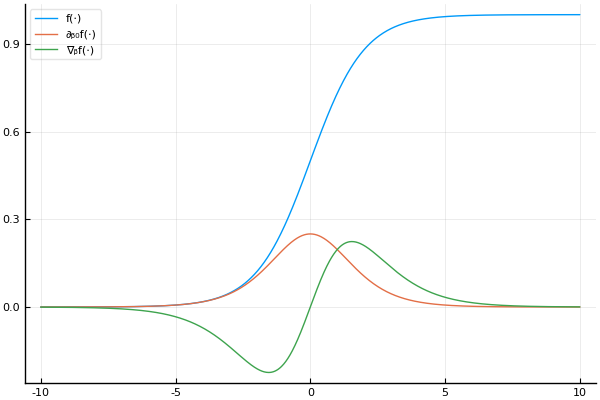

In [29]:
xplotvals = range(-10, stop=10, length=1000)
plot(xplotvals, hcat(f.(xplotvals, 1, 0), ∂ᵦ₀f.(xplotvals, 1, 0), ∇ᵦf.(xplotvals, 1, 0)),
    background_color=RGBA(1,1,1,0.1), labels=["f(⋅)" "∂ᵦ₀f(⋅)" "∇ᵦf(⋅)"])

Define the loss function and its gradients

In [108]:
loss(y, x, β, β₀, λ) = log(1 + exp(-y * f(x, β, β₀))) + λ * (sum(abs.(β)) + abs(β₀))
∂ᵦ₀loss(y, x, β, β₀, λ) = -y * ∂ᵦ₀f(x, β, β₀) * exp(-y * f(x, β, β₀)) / (1 + exp(-y * f(x, β, β₀))) + λ * sign(β₀)
∇ᵦloss(y, x, β, β₀, λ) = -y * ∇ᵦf(x, β, β₀) * exp(-y * f(x, β, β₀)) / (1 + exp(-y * f(x, β, β₀))) + λ * sign.(β)
;

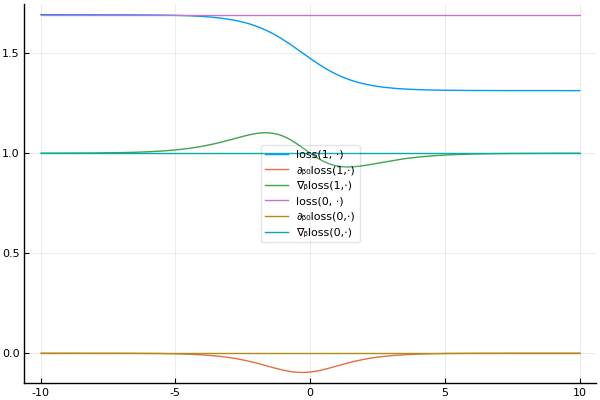

In [105]:
plot(xplotvals, hcat(
        loss.(1, xplotvals, 1, 0, 1), ∂ᵦ₀loss.(1, xplotvals, 1, 0, 1), ∇ᵦloss.(1, xplotvals, 1, 0, 1),
        loss.(0, xplotvals, 1, 0, 1), ∂ᵦ₀loss.(0, xplotvals, 1, 0, 1), ∇ᵦloss.(0, xplotvals, 1, 0, 1)
    ),
    background_color=RGBA(1,1,1,0.1), labels=["loss(1, ⋅)" "∂ᵦ₀loss(1,⋅)" "∇ᵦloss(1,⋅)" "loss(0, ⋅)" "∂ᵦ₀loss(0,⋅)" "∇ᵦloss(0,⋅)"])

Generate some test data

In [143]:
rng = MersenneTwister(1846)

datatype = Float32
m = 10 # number of useful features
M = 100 # total number features
N = 100000 # total number of examples
model_β = zeros(datatype, M)
model_β[1:m] = randn(rng, datatype, m)
model_β₀ = randn(rng, datatype)
X = randn(rng, datatype, (M, N))
model_PX = mapslices(x -> f(x, model_β, model_β₀), X, dims=1)[1,:]
y = datatype.(rand(rng, datatype, N) .< model_PX)
sum(y)

36447.0f0

Start with a guess of the parameters and use gradient descent to improve them

Epoch 10, loss 58479.453
Epoch 20, loss 56977.902
Epoch 30, loss 56287.4
Epoch 40, loss 55974.477
Epoch 50, loss 55819.477
Epoch 60, loss 55733.08
Epoch 70, loss 55679.69
Epoch 80, loss 55643.99
Epoch 90, loss 55618.72
Epoch 100, loss 55600.074
 34.113780 seconds (320.23 M allocations: 114.569 GiB, 14.31% gc time)


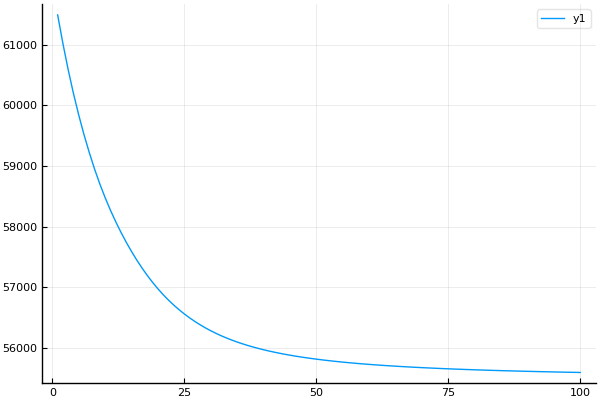

In [144]:
function fit(X, y)
    
    # initial guesses of parameters
    rng = MersenneTwister(1811)
    β = randn(rng, eltype(X), size(X)[1])
    β₀ = randn(rng, eltype(X))
    λ = 1e-10
    
    numepochs = 100
    η(epoch) = 1e-2 / (10 + epoch)
    losses = Array{eltype(X)}(undef, numepochs)

    for epoch in 1:numepochs
        losses[epoch] = sum(loss(y[i], X[:,i], β, β₀, λ) for i in 1:length(y))
        
        for i in 1:length(y)
            β -= η(epoch) * ∇ᵦloss(y[i], X[:,i], β, β₀, λ)
            β₀ -= η(epoch) * ∂ᵦ₀loss(y[i], X[:,i], β, β₀, λ)
        end
        losses[epoch] = sum(loss(y[i], X[:,i], β, β₀, λ) for i in 1:length(y))
        if epoch % 10 == 0
            print("Epoch $(epoch), loss $(losses[epoch])\n")
        end
    end
    
    return losses, β, β₀
end

@time losses, fit_β, fit_β₀ = fit(X, y)
plot(losses, background_color=RGBA(1,1,1,0.1))

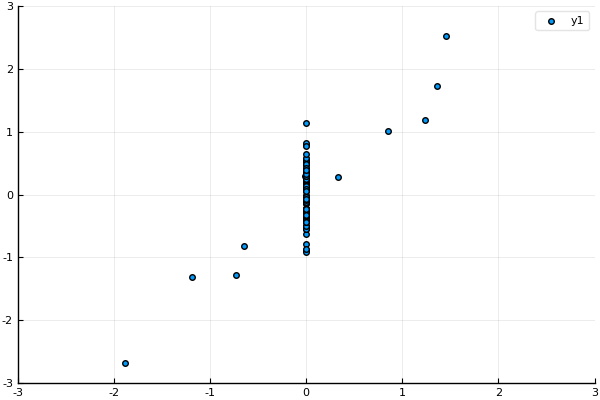

In [145]:
plot(model_β, fit_β, seriestype=:scatter, xlim=(-3, 3), ylim=(-3, 3), background_color=RGBA(1,1,1,0.1))